# Player Matching

## Problem Description
Predicting the outcome of a match between two players can help match two players. 


## Project Description
In this challenge, a historical data `dataset.csv` is analyzed and machine learning is employed to predict the probability of `player1_win_player2` based on its paramerters, including `player1_skill1`, and `player2_skill`. 

 A detailed data description can be accessed from `takehome_test.py` or the problem instruction.

In overall, the following procedures were done in this project, including: 

1. Preprocess, clean, analyze and visualized the provided data.

2. Feature engineering

3. Model building, performance evaluation and prediction. 

4. Summary and recommendation.

# Table of  Contents

- Part 1 Pre-model Analysis
  - 1.1 Data set overview
  - 1.2 Target feature processing and visualization
  
  
- Part 2 Feature Engineering
  
- Part 3 Machine Learning Model
  - 3.1 Model selection and comparision
  - 3.2 Model hyperparameter tuning


- Part 4 Machine Learning Prediction

- Part 5 Project Summary

In [1]:
pip install xgboost

You should consider upgrading via the '/home/dianxun/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# Part 1. Pre-model Analysis

## 1.1 Data set overview

In [3]:
# Loding the data
pm_raw = pd.read_csv('dataset.csv').drop(['Unnamed: 0'], axis=1)
pm_raw.head()

,player1_id,player2_id,player1_skill,player2_skill,winner_id
0,1066,414,128.0,178.8,1066.0
1,304,893,182.6,148.0,893.0
2,544,893,210.4,148.0,544.0
3,1158,1011,168.0,207.6,1011.0
4,22,154,288.6,231.4,154.0


In [4]:
# Data Information, including shape and type
pm_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player1_id     2120 non-null   int64  
 1   player2_id     2120 non-null   int64  
 2   player1_skill  2106 non-null   float64
 3   player2_skill  2096 non-null   float64
 4   winner_id      2118 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 82.9 KB


In [5]:
# Check if the dataset contains duplicate observation; 
# if true, consider to remove the duplicates.
print(pm_raw.duplicated().any())
# pm_raw = pm_raw.drop_duplicates()

True


- There are some duplicate record in the `dataset.csv`. Since these duplicates have different index and supposed to be some different games, considering the model is to give an probaility in overall based on all players and all games, it is decided keep those duplicate records.

In [6]:
# define a function for checking the missing percentage of each column
def calculate_missing_perc(x):
    '''
    function: check the percentage of missing value of each column in a dataframe
    input: dataframe
    output: dictionary
    '''
    dic = {}
    for feature in x.columns:
        perc = round(x[feature].isnull().sum()/len(x)*100, 2)
        dic[feature] = str(perc) + '%'
    
    return dic

calculate_missing_perc(pm_raw)

{'player1_id': '0.0%',
 'player2_id': '0.0%',
 'player1_skill': '0.66%',
 'player2_skill': '1.13%',
 'winner_id': '0.09%'}

**Part Summary**
- A minimal fraction of missing values (0.66%, 1.13% and 0.09%) were observed for `player1_skill`, `player2_skill`, `winner_id`. 

- Though the information is important, since their portions are small, it is decided to remove them from the whole data set rather do imputation which may bring bias to the model. 

In [7]:
# drop all records with missing price value
pm_raw.dropna(subset=['player1_skill','player2_skill','winner_id'], inplace = True)
pm_raw.shape

(2080, 5)

**Part Summary**
- After removing the missing values, the data set still has 2080 rows, which is 98% of the original (2120), and still good for training.

## 1.2 Target feature processing and visualization

Ahead of processing the target feature, the data set is transformed into a total new one, with keeping only three columns, including `player1_skill` `player2_skill`, `player1_win_player2`. If player1 wins player2, player1_win_player2 is marked '1', else as '0'.

In [8]:
# Creat new data frame, namely pm_new, 
pm_new = pd.DataFrame() 
pm_new = pm_raw.loc[:,'player1_skill':'player2_skill']
pm_new['player1_win_player2'] = pm_raw.apply(lambda x: 1 if x['player1_id'] == x['winner_id'] else 0, axis=1)
pm_new.head()

,player1_skill,player2_skill,player1_win_player2
0,128.0,178.8,1
1,182.6,148.0,0
2,210.4,148.0,1
3,168.0,207.6,0
4,288.6,231.4,0


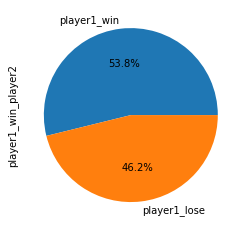

In [9]:
#check data balance
labels = 'player1_win', 'player1_lose', 
pm_new.player1_win_player2.value_counts().plot(kind = 'pie', labels = labels, autopct='%1.1f%%')
plt.show()

**Part Summary**
- In `player1_win_player2`, there are ~54% win (1) and ~46% lose (0), indicating the data in a balanced form and there is no much need to control the imbalance during modeling.

# Part 2 Feature Engineering

It is easily observed that all the features are continous numerical features and there is no need to encode such features. The only process is to check the distribution of those data. 

### Note: 
It is not sure whether the features, the values of `id`, either `player1_id` and `player2_id` are important or not in results prediction, since they are not used in the final prediction (as suggested by input arguments of the python file), this jupyter notebook does not consider such features. But it may be interesting to investigate whether such feature is numerical feature, or categorical feature, which needs encoding.

In [10]:
# Visualize the distribution of all features
pm_new.describe()

,player1_skill,player2_skill,player1_win_player2
count,2080.000000,2080.000000,2080.000000
mean,223.156058,208.367692,0.538462
std,62.677605,54.332490,0.498638
min,23.000000,72.000000,0.000000
25%,176.000000,171.400000,0.000000
50%,231.700000,207.200000,1.000000
75%,278.600000,245.000000,1.000000
max,359.000000,341.600000,1.000000


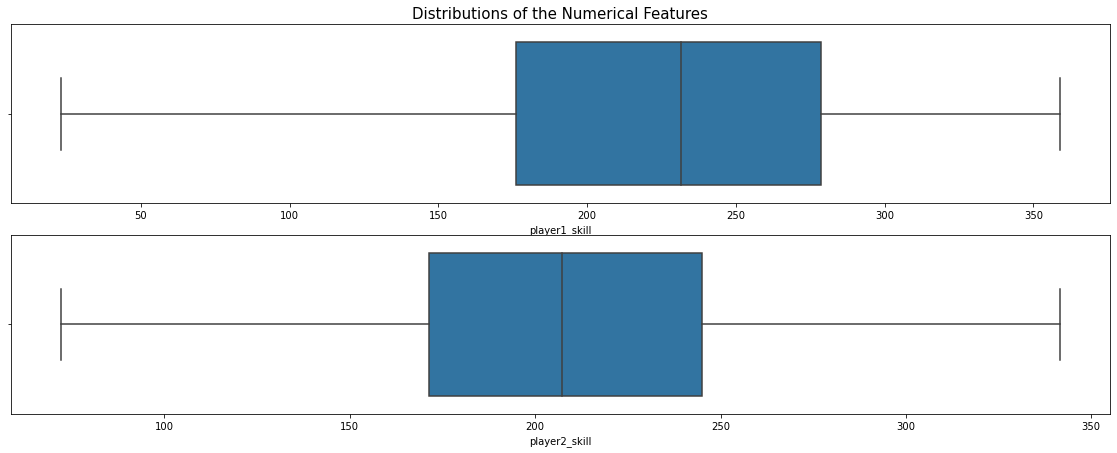

In [11]:
# Plot the box plots of prediction results of all models
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
fig.tight_layout()
sns.boxplot(ax = ax[0], x=pm_new.player1_skill)
sns.boxplot(ax = ax[1], x=pm_new.player2_skill)
ax[0].set_title('Distributions of the Numerical Features', fontsize=15)

plt.show()

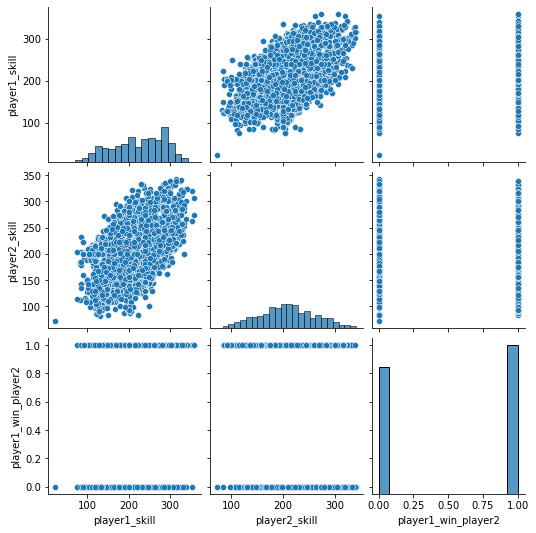

In [12]:
#pair plot of the data
sns.pairplot(pm_new)
plt.show()

**Part Summary**
- There is no outliers observed. 

- And all the features except the target demonstrate Gaussian distribution, except `player1_skill` shows a little bit of negtively skewed. 

- In overall, the data set is good for direct modeling

# Part 3. Machine Learning Model

## 3.1 Model selection and comparison

Since the data set is now clean and organized and all numerical, there is no need to build data transformers for data transformation.

### **(1) Data Splitting using `train_test_split`**<br>

In [13]:
# Data Preprocessing (transform first, split second)
target = 'player1_win_player2'     
y = pm_new[target]
X = pm_new.drop(columns=['player1_win_player2'], axis=1)

In [14]:
# Data Splitting (train_test_split Cross Validation)
X_train, X_test, y_train, y_test =  train_test_split(X, 
                                                     y, 
                                                     test_size = 0.2,
                                                     random_state = 2021)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

### **(2) Modeling Performance and Selection**<br>

Logistic regression, Random Forest, Gradient Boosting and XGBoost, were chosen as the model candidates. As these are the mostly commonly used models.


Once a model is selected, its hyperparameters will be tuned. 

In [15]:
# Build the pipleines for all models
steps_lr = [('rescale', StandardScaler()),
         ('lr', LogisticRegression(n_jobs = -1))]

steps_rfc = [('rescale', StandardScaler()), 
         ('rfc', RandomForestClassifier(n_jobs = -1))]

steps_gbc = [('rescale', StandardScaler()),
             ('gbc', GradientBoostingClassifier())]

steps_xgb = [('rescale', StandardScaler()),    
         ('xgb', XGBClassifier(n_jobs=-1))]

In [16]:
#Fit data into the model
model_lr = Pipeline(steps_lr)
model_lr = model_lr.fit(X_train, y_train)

model_rfc = Pipeline(steps_rfc)
model_rfc = model_rfc.fit(X_train, y_train)

model_gbc = Pipeline(steps_gbc)
model_gbc = model_gbc.fit(X_train, y_train)

model_xgb = Pipeline(steps_xgb)
model_xgb = model_xgb.fit(X_train, y_train)

[01:58:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
#Lgistic Regression prediction
y_train_pred_lr = model_lr.predict(X_train)
y_test_pred_lr = model_lr.predict(X_test)

y_train_pred_proba_lr = model_lr.predict_proba(X_train)
y_test_pred_proba_lr = model_lr.predict_proba(X_test)

LogisticRegression_Loss = pd.DataFrame({'model': 'Logistic Regression',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_lr).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_lr).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_lr[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_lr[:, 1]).round(4)}, index=[0])

In [18]:
#Random Forest prediction
y_train_pred_rfc = model_rfc.predict(X_train)
y_test_pred_rfc = model_rfc.predict(X_test)

y_train_pred_proba_rfc = model_rfc.predict_proba(X_train)
y_test_pred_proba_rfc = model_rfc.predict_proba(X_test)

RandomForest_Loss = pd.DataFrame({'model': 'Random Forest',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_rfc).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_rfc).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_rfc[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_rfc[:, 1]).round(4)}, index=[0])

In [19]:
#Gradient Boosting prediction
y_train_pred_gbc = model_gbc.predict(X_train)
y_test_pred_gbc = model_gbc.predict(X_test)

y_train_pred_proba_gbc = model_gbc.predict_proba(X_train)
y_test_pred_proba_gbc = model_gbc.predict_proba(X_test)

GradientBoosting_Loss = pd.DataFrame({'model': 'Gradient Boosting',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_gbc).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_gbc).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_gbc[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_gbc[:, 1]).round(4)}, index=[0])

In [20]:
#XGBoost prediction
y_train_pred_xgb = model_xgb.predict(X_train)
y_test_pred_xgb = model_xgb.predict(X_test)

y_train_pred_proba_xgb = model_xgb.predict_proba(X_train)
y_test_pred_proba_xgb = model_xgb.predict_proba(X_test)

XGBoost_Loss = pd.DataFrame({'model': 'XGBoost',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_xgb).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_xgb).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_xgb[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_xgb[:, 1]).round(4)}, index=[0])

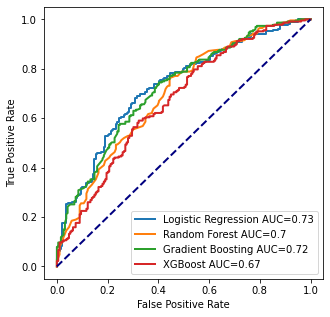

In [21]:
#define metrics
plt.figure(figsize = (5,5))
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']
y_test_pred_proba = []
y_test_pred_proba.append(y_test_pred_proba_lr[:, 1])
y_test_pred_proba.append(y_test_pred_proba_rfc[:, 1])
y_test_pred_proba.append(y_test_pred_proba_gbc[:, 1])
y_test_pred_proba.append(y_test_pred_proba_xgb[:, 1])

#create ROC curve
for n in range(len(y_test_pred_proba)):
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba[n])
    auc = roc_auc_score(y_test, y_test_pred_proba[n])
    lw = 2
    plt.plot(fpr,tpr,label=str(models[n])+" AUC="+str(auc.round(2)),lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [22]:
## Build a model_scores showing the scores of all models
model_scores = pd.concat([LogisticRegression_Loss,
                          RandomForest_Loss, 
                          GradientBoosting_Loss,
                          XGBoost_Loss])
model_scores

,model,train_accuracy,test_accuracy,train_auc,test_auc
0,Logistic Regression,0.6803,0.6779,0.7396,0.7265
0,Random Forest,0.9988,0.6394,1.0000,0.6954
0,Gradient Boosting,0.7524,0.6731,0.8439,0.7201
0,XGBoost,0.9153,0.6154,0.9749,0.6699


**Part Summary**
- From the score table and plot above, it is clear to see that Logistic Regression indicates almost no variance between the train and test, and the highst test_auc score (0.73) than the other tree based models. Since 0.73 is pretty good for classification, we thereafter use logistic regression model for future prediction. Gradient boosting shows comparable performance with logistic regression. 

- Differently, the tree based models, including random forest and XGboost, indicate very high variance and low auc score. It is suggested that tuning may be needed, or more features may derived  for better performance. 

- Though we have chose logistic regression as our model, and also limitted by time and high variance itself, a rough tuning is conducted on random forest. 

## 3.2 Model hyperparameter tuning (Random Forest)

### **(1) Tuning**<br>

RandomSearchCV can be used to narrow down the range for each hyperparameter, while GridSearchCV is employed here fore hyperparameters tuning. The following hyperparameters are tuned, including `max_depth`, `min_samples_leaf`, `min_samples_split`, `max_features` and `n_estimators`. 

In [23]:
## Applying Grid Search to find the best model and the best parameters

#Define the hyperparameters to tune
grid_parameters = {'rfc__max_depth': [None, 2, 10],
              'rfc__n_estimators': [20, 50, 100],
              'rfc__class_weight': [None, 'balanced']
             }


#Define the gridsearch process
grid_search = GridSearchCV(model_rfc, 
                           grid_parameters, 
                           cv = 3, 
                           scoring = 'roc_auc', 
                           n_jobs = -1,
                           return_train_score=True)

#Applying tuning and timers
grid_search_rfc = grid_search.fit(X_train, y_train)

In [24]:
grid_search_rfc.best_params_

{'rfc__class_weight': 'balanced', 'rfc__max_depth': 2, 'rfc__n_estimators': 20}

In [25]:
model_rfc_tune = grid_search_rfc.best_estimator_

### **(2) After Tuning**<br>

In [26]:
#Random Forest prediction
y_train_pred_rfc_tune = model_rfc_tune.predict(X_train)
y_test_pred_rfc_tune = model_rfc_tune.predict(X_test)

y_train_pred_proba_rfc_tune = model_rfc_tune.predict_proba(X_train)
y_test_pred_proba_rfc_tune = model_rfc_tune.predict_proba(X_test)

RandomForest_Loss_Tuned = pd.DataFrame({'model': 'Random Forest after Tuning',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_rfc_tune).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_rfc_tune).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_rfc_tune[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_rfc_tune[:, 1]).round(4)}, index=[0])

model_scores = pd.concat([model_scores,
                          RandomForest_Loss_Tuned])
model_scores

,model,train_accuracy,test_accuracy,train_auc,test_auc
0,Logistic Regression,0.6803,0.6779,0.7396,0.7265
0,Random Forest,0.9988,0.6394,1.0000,0.6954
0,Gradient Boosting,0.7524,0.6731,0.8439,0.7201
0,XGBoost,0.9153,0.6154,0.9749,0.6699
0,Random Forest after Tuning,0.6803,0.6250,0.7444,0.7011


**Part Summary**

- Tuning not only reduces the variance much but also improves model performance (~3.2% increase in test AUC). 

- Better server with better computation power may be employed for fine tuning and better performance.

### **(3) Feature Importance**<br>

Though there is only two features in this data set, the feature importance is still compared to check potential hidden information. 

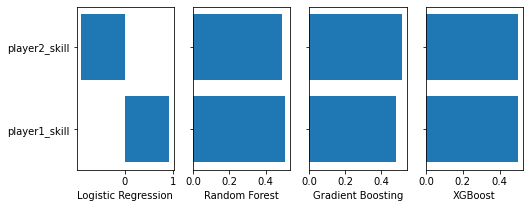

In [27]:
# Plot feature importance of all four models
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8,3), sharey=True)

ax[0].barh(X.columns, model_lr.steps[1][1].coef_[0]) #Rescaled
ax[1].barh(X.columns, model_rfc.steps[1][1].feature_importances_)
ax[2].barh(X.columns, model_gbc.steps[1][1].feature_importances_)   
ax[3].barh(X.columns, model_xgb.steps[1][1].feature_importances_)

ax[0].set_xlabel('Logistic Regression', fontsize=10)
ax[1].set_xlabel('Random Forest', fontsize=10)
ax[2].set_xlabel('Gradient Boosting', fontsize=10)
ax[3].set_xlabel('XGBoost', fontsize=10)

plt.show()

**Part Summary**

- The two features indicate comparable importance in all the models  

# Part 4. Machine Learning Model Prediction

As future prediction is not conducted in this part, here we just save the logistic regression model for the `takehome_test.py` for future use, and show a simple case of how to use this model.

### **(1) Modeling Save**<br>

In [28]:
#save the model as pickle file
import pickle

Pkl_Filename = "player_matching_lr.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model_lr, file)

In [29]:
#check the saved pickle model
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

In [30]:
Pickled_LR_Model

Pipeline(steps=[('rescale', StandardScaler()),
                ('lr', LogisticRegression(n_jobs=-1))])

### **(2) Modeling Prediction**<br>

Here only logistic regression is used as an example, mutilple models can be run and obtain multiple results for cross validation.

In [31]:
#prediction example

class Player:
    def __init__(self, name, skill):
        self.name = name
        self.skill = skill
        
def predict_outcome(player1, player2):
    # fill in the body of this function

    import pickle
    import pandas as pd
    Pkl_Filename = "player_matching_lr.pkl"  
    
    with open(Pkl_Filename, 'rb') as file:  
        Pickled_LR_Model = pickle.load(file)
        
    
    new_match = pd.DataFrame({'player1_skill':[player1.skill],
                             'player2_skill':[player2.skill]})
                             
    return Pickled_LR_Model.predict_proba(new_match)[0][1].round(3)

# example usage:
arpad = Player('Arpad', 365)
mark = Player('Mark', 341)

result = predict_outcome(arpad, mark)
print('The probability that Arpad will beat Mark is:', result)

The probability that Arpad will beat Mark is: 0.514


# Part 5. Project Summary

In this project, machine learning models were built to predict the portability of winning. 

Before modeling, the raw data as checked and cleaned (dropped). Since all features are numerical, no encoding was employed. 

As for the modeling, four most widely used models, including Logistic Regression, Random Forest, Gradient Boosting and XGBoost, were employed and compared. Their performance on the training and test sets is summerized below: 

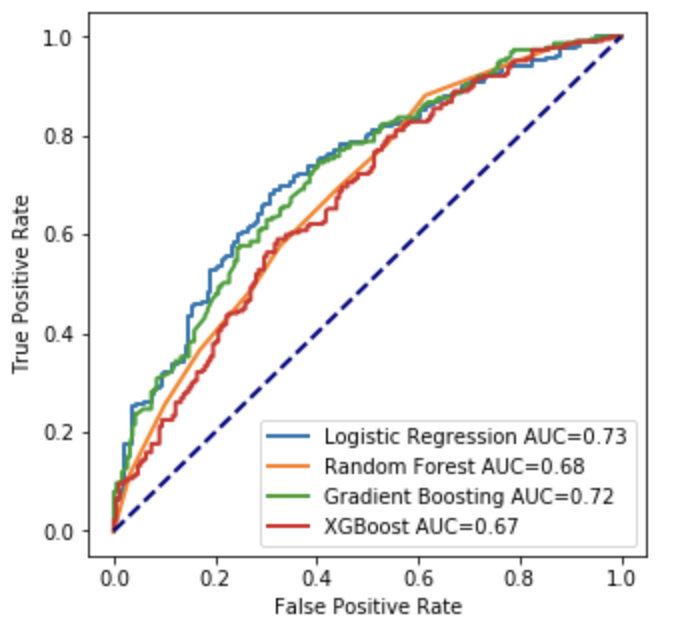

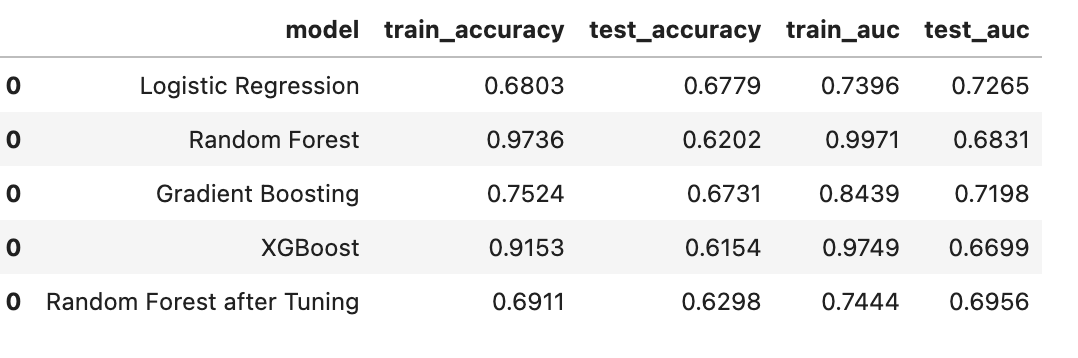

From the ROC AUC curves above, it is clear to see that Logistic Regression indicates almost no variance between the train and test and the best performance. Differetly, all tree based models, except Gradient Boosting, show huge variance (overfitting). Since Random Forest shows very high variance, Random Forest model is tuned to reduce the variance,.

From the training and test loss, tuning reduces the variance a lot and improves much of model performance. Since the variance after tune is still high, better server with better computation power may be employed for fine tuning and better performance. As the tuned model still underperforms than logistic regression, the latter is chosen as our model in future prediction.